# Sentiment Analysis with an RNN using Word Embedding

The following implements word embedding to learn the sentiment (positive or negative) or movie reviews

In [1]:
# DON'T MODIFY THIS CELL

# import os
# os.environ["CUDA_VISIBLE_DEVICES"]="-1" 

# import some modules
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
from keras.optimizers import RMSprop
import pandas as pd
import numpy as np
import re
import requests
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
# DON'T MODIFY THIS CELL

# import the data
reviews_url = 'https://raw.githubusercontent.com/prof-groff/deep-learning/master/data/sentiment/reviews.txt'
labels_url = 'https://raw.githubusercontent.com/prof-groff/deep-learning/master/data/sentiment/labels.txt'
reviews = requests.get(reviews_url).text
labels = requests.get(labels_url).text

# do some additional preprocessing
reviews = re.sub(' br ','', reviews) # remove random remnants of <br> tags
reviews = re.sub('\n', 'newline_char', reviews) # temporarily remove \n characters
reviews = re.sub('\s+', ' ', reviews) # remove all special characters and extra spaces
reviews = re.sub('newline_char', '\n', reviews) # replace the \n characters

# split the reviews and lables text at \n characters to make lists
reviews_list = reviews.split('\n')[0:-1] # for some reason the last element is junk
labels_list = labels.split('\n')[0:-1]

In [3]:
# DON'T MODIFY THIS CELL

# look at an example negative and positive review
print(labels_list[1001].upper())
print('\n')
print(reviews_list[1001])
print('\n')
print(labels_list[1002].upper())
print('\n')
print(reviews_list[1002])


NEGATIVE


this movie was the worst movie i have seen since date movie . i was laughing through out the whole movie instead of being scared . it was funny how the snakes would search for particular section of the passengers body to attack for example the eye the tongue the butt the breast . if we have seen national geographic channel we know snakes wont stay clinched on the body once they bite . for each particular scene the snakes would bite the passengers and would stay on the body biting the person . i believe the producer did not study his information on snakes and their behavior . i cant believe i wasted my money on this movie . so i don t recommend this movie trust just wait until it is at the dollar theatre or rent it . 


POSITIVE


 before sunrise is a wonderful love story and has to be among my top favorite movies ever . dialog and acting are great . i love the characters and their ideas and thoughts . of course the romantic vienna introduced in the movie does not exist you w

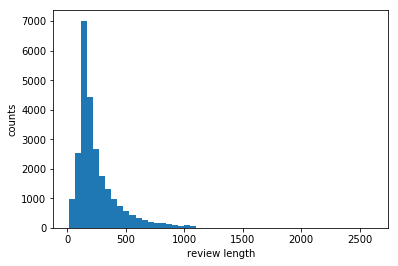

In [4]:
# DON'T MODIFY THIS CELL

# look at the distribution of review lengths (# of words)
# some of the reviews are really long but most are under 500 words long
review_lengths = []
for each in reviews_list:
    review_lengths.append(len(each.split()))

plt.hist(review_lengths,bins=50)
plt.ylabel('counts')
plt.xlabel('review length')
plt.show()    

In [5]:
# TO-DO: PICK A MAX_LENGTH (AT LEAST 100) AND TRIM THE DATA TO ONLY THOSE REVIEWS 
# WITH NO MORE THAN THIS MANY WORDS
max_length = 300

# DO NOT MODIFY THIS CELL BELOW THIS POINT

reviews_trimmed = []
labels_trimmed = []

for r, l in zip(reviews_list, labels_list):
    if len(r.split())<= max_length:
        reviews_trimmed.append(r)
        labels_trimmed.append(l)
        
print('TOTAL REVIEWS: ' + str(len(reviews_list)))
print('REVIEWS WITH < ' + str(max_length) + ' WORDS: ' + str(len(reviews_trimmed)))

TOTAL REVIEWS: 25000
REVIEWS WITH < 300 WORDS: 18678


In [6]:
# DO NOT MODIFY THIS CELL

# determine the number of unique words in the reviews
vocab = set(' '.join(reviews_trimmed).split())
vocab_length = len(vocab)+1 # add one so zero is reserved for padding
print('VOCAB LENGTH: ' + str(vocab_length))

VOCAB LENGTH: 53812


In [7]:
# DO NOT MODIFY THIS CELL

# a function to create mappings between words and integers
# each integer is a key for each word and vice versa
def create_lookup_tables(vocab):
    # enumerate adds an index to each word in the vocab and returns a list of tuples
    int_to_vocab = dict(enumerate(vocab, 1))
    vocab_to_int = dict(zip(int_to_vocab.values(), int_to_vocab.keys()))
    
    return vocab_to_int, int_to_vocab

vocab_to_int, int_to_vocab = create_lookup_tables(vocab)

In [8]:
# DO NOT MODIFY THIS CELL

# the following tokenizes the reviews and labels
n_reviews = len(reviews_trimmed)
reviews_vect = np.zeros([n_reviews, max_length])
labels_vect = np.zeros([n_reviews,2])
for ii, r, l in zip(np.arange(n_reviews), reviews_trimmed, labels_trimmed):
    words = r.split()
    n_words = len(words)
    for jj, w in zip(np.arange(n_words), words):
        reviews_vect[ii, max_length-n_words+jj] = vocab_to_int[w]
    if l == 'positive':
        labels_vect[ii,1]=1
    else:
        labels_vect[ii,0]=1

In [9]:
# DO NOT MODIFY THIS CELL

# look at an example tokenized review

print(labels_trimmed[0].upper())
print('\n')
print(reviews_trimmed[0])
print('\n')
print(reviews_vect[0])

POSITIVE


bromwell high is a cartoon comedy . it ran at the same time as some other programs about school life such as teachers . my years in the teaching profession lead me to believe that bromwell high s satire is much closer to reality than is teachers . the scramble to survive financially the insightful students who can see right through their pathetic teachers pomp the pettiness of the whole situation all remind me of the schools i knew and their students . when i saw the episode in which a student repeatedly tried to burn down the school i immediately recalled . . . . . . . . . at . . . . . . . . . . high . a classic line inspector i m here to sack one of your teachers . student welcome to bromwell high . i expect that many adults of my age think that bromwell high is far fetched . what a pity that it isn t 


[    0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
     0.     0.     0.     0. 

In [10]:
# TO-DO: BREAK THE DATA INTO A TRAINING, VALIDATION, AND TESTING SETS 
# WITH AT LEAST 1000 ELEMENTS IN THE VALIDATION AND TESTING SETS
val_size = 1000
test_size = 1000

# DO NOT MODIFY THIS CELL BELOW THIS POINT

x_train, x_val, x_test = reviews_vect[:-(val_size+test_size)], reviews_vect[-(val_size+test_size):-test_size], reviews_vect[-test_size:]
y_train, y_val, y_test = labels_vect[:-(val_size+test_size)], labels_vect[-(val_size+test_size):-test_size], labels_vect[-test_size:]

In [11]:
# TO-DO: SELECT MODEL SIZE PARAMETERS
embedding_size = 256
memory_units = 128

# TO-DO: SELECT HYPERPARAMETERS
batch_size = 256
epochs = 1
learning_rate = 0.003

# TO DO: BUILD A MODEL WITH EMBEDDING, ONE LSTM LAYER, AND ONE DENSE 
# OUTPUT LAYER WITH TWO OUTPUT UNITS
print('build model...'.upper())
model = Sequential()
model.add(Embedding(input_dim=vocab_length, output_dim=embedding_size, input_length=max_length))
model.add(LSTM(memory_units, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2, activation='softmax'))

optimizer = RMSprop(lr=learning_rate)
# ALTERNATIVE OPTIMIZER
# optimizer = 'adam'

model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

model.summary()
print('\ntrain...\n'.upper())
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(x_val, y_val))
score, acc = model.evaluate(x_test, y_test,
                            batch_size=batch_size)
print('\ntest score: '.upper() + str(score))
print('test accuracy: '.upper() + str(acc))


BUILD MODEL...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 300, 256)          13775872  
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               197120    
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 258       
Total params: 13,973,250
Trainable params: 13,973,250
Non-trainable params: 0
_________________________________________________________________

TRAIN...

Train on 16678 samples, validate on 1000 samples
Epoch 1/1
1000/1000 [==============================] - 0s 378us/step

TEST SCORE: 0.51607643699646
TEST ACCURACY: 0.7689999980926514


In [12]:
# TO-DO: PICK A TEST CASE
# let's look at a specific review and compare the predicted sentiment to the actual sentiment

test_case = 410 # index of one of the reviews in the test set

# DO NOT MODIFY THIS CELL BELOW THIS POINT

x = x_test[test_case]
y = y_test[test_case]

# convert from tokens back to text
test_review = []
for each in x:
    if each != 0:
        test_review.append(int_to_vocab[each])

test_review = ' '.join(test_review)

# look at an example negative and positive review
print('predicting sentiment of following review...\n'.upper())
print(test_review)
print('\n')

print('passing the review through the trained model...\n'.upper())
x = np.reshape(x, (1,len(x)))
y_prime = model.predict(x)
print('predicted sentiment - 0 - negative, 1 - positive'.upper())
print(y_prime[0])
print(['negative', 'positive'][np.argmax(y_prime[0])].upper())
print('\n')
print('actual sentiment'.upper())
print(['negative', 'positive'][np.argmax(y)].upper())


PREDICTING SENTIMENT OF FOLLOWING REVIEW...

i just wondering what is the purpose of making movies like this the profit and to whom they are referring what intelligence must use your brain to watch something like this crap this movie is watchable by under years old children if you are adults don t try to watch it . thats the reason i think hollywood started to use cartoons in movies with actors like this you must forget the art of cinema be sure that you ll have tons of pop corn to consume for time to pass till this movie ends also get many cola s hamburgers your laptop your cellphone this movie can be used easily in a restaurant but for sure not in a theater my dog who is always next to my family when watching a movie left the building . the sure thing is that this movie is referring to people with no demands from the cinema art . the only thing that this movie can be used is for watching it when making the supermarket shopping list . i am giving stars for supporting the india s cinem

In [13]:
# CHALLENGE: WRITE YOUR OWN REVIEW AN USE THE MODEL TO PREDICT ITS SENTIMENT